In [9]:
import dicom
from glob import glob
from os.path import join, basename
from IPython.display import clear_output
%pylab inline
from scipy.misc import imsave, imresize

import time
import pylab as pl
from IPython import display

gray();

Populating the interactive namespace from numpy and matplotlib


/home/analytics/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imsave', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data_file = np.load("../pickles/data.npz")
images = data_file["X"]

In [3]:
images[0].shape

(1024, 1024)

In [4]:
IMAGE_SIZE = images[0].shape[0]

In [10]:
images_dw = np.array([imresize(img, [128, 128]) for img in images])

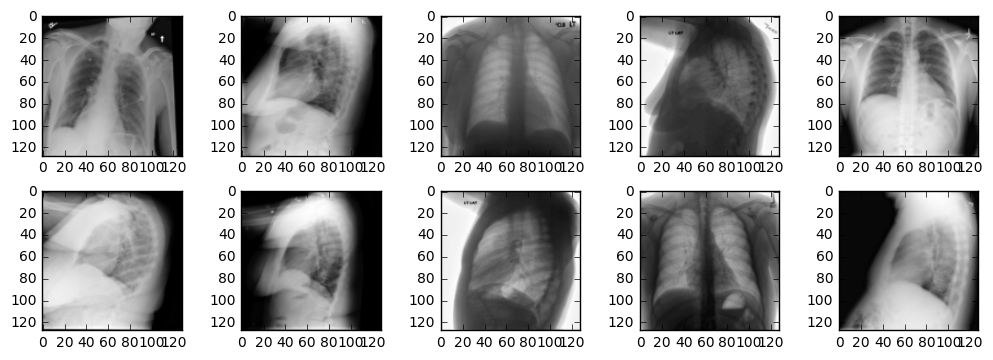

flflflllfl
11.07978367805481


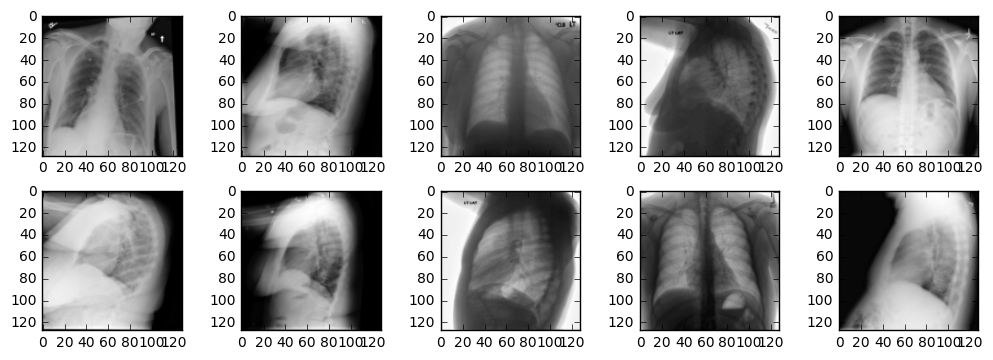

In [15]:
orientations = np.empty((len(images)), dtype=str)

plt.ion()
plt.set_cmap("gray")

cur_images = np.empty((10, IMAGE_SIZE, IMAGE_SIZE))

fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images_dw[:1000]):
    start_time = time.time()
    print(i)
    splt = fig.add_subplot(2, 5, i % 10 + 1)
    
    plt.imshow(image)
    
    if i % 10 == 9:
        display.clear_output(wait=False)
        display.display(pl.gcf())
        time.sleep(.1)
        ors = []
        while len(ors) != 10:
            ors = list(input())
            if any([l not in ["l", "f"] for l in ors]):
                ors = []
                continue
        orientations[(i // 10) * 10:((i // 10) + 1) * 10] = ors
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.1)
    
    print(time.time() - start_time)

In [21]:
images.mean(axis=1).shape

(7470, 1024)

In [26]:
features = np.concatenate([images[:1000].mean(axis=1), images[:1000].mean(axis=2)], axis=1)
targets = orientations[:1000]
targets[targets == "l"] = 0
targets[targets == "f"] = 1

In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [37]:
train_idx, test_idx = train_test_split(np.arange(len(features)))
X_train, X_test, Y_train, Y_test = features[train_idx], features[test_idx], targets[train_idx], targets[test_idx]

In [42]:
params = {
    "max_depth": [3, 4, 5, 6], 
    "n_estimators": [100, 200, 500, 1000],
}

clf = XGBClassifier()
grid = GridSearchCV(clf, param_grid=params)
grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500, 1000], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
grid.score(X_test, Y_test)

0.95199999999999996

In [45]:
predicted_orientations = grid.predict(features)

In [46]:
np.savez_compressed("../pickles/orientations.npz", predicted=predicted_orientations)